Hello friends. On my journey to becoming a Data Analyst and studying A/B tests, I stumbled upon the importance of correctly assessing the significance of our results. I want to note that this publication will serve as a kind of consolidation of what I've read in an article. And one more note about this Notebook, I also took it from an internet resource. So, when we introduce our innovation, we need to understand how it will reflect on our product, and is it really better? Even if we have obtained statistically significant differences, for example, between the means, we now need to understand if our result was obtained by chance? And this is very important. If we incorrectly assess the test, we risk making a false conclusion. To date, on my journey, I have encountered several statistical tests that can check for significance, such as t-test, Mann–Whitney U test, z-test, bootstrap, monte-carlo. Yes, so far this is a small set of "tools" in my baggage, and furthermore, I cannot boast that I am already an expert in these topics, but nevertheless, I have already understood something. And that's what I want to write about here. In this notebook, we will consider three types of statistical tests. Let the first one be the T-test. The T-test is a powerful test for checking significance, and it is (as far as I know) quite often used in the industry, however, it has some limitations. Let's discuss what exactly. One of the main limitations is that the variances in the samples should be approximately equal. This problem is also described on the internet as follows: "With unequal variances and sample sizes, we encounter the Behrens-Fisher problem, which until recently was considered unsolvable. Then a solution was found, but it is unpopular and complex, and everyone uses Welch's method. The Welch test process usually involves calculating the test statistic, which is then compared to the critical value from the corresponding distribution (usually the t-distribution). If the test statistic exceeds the critical value, then the null hypothesis of equal variances is rejected." However, when we learn about the T-test, the Welch formula was default. Now let's recall the fact that the T-test requires normality of data. Until recently, I also thought so until I read that this is not entirely true. However, this is problem 2. The thing is that the T-test does not require normality of data in its original form, but requires normality in the distribution of means. Usually, we always calculate mean values to detect statistical significance. And statistical significance is observed when we calculate the P-value for each of the values taken from the sample, and we need to understand the distribution form of this "statistic". It is also necessary to remember that there is the central limit theorem, which tells us that the mean value of a metric over a sufficiently large sample of users will have a normal distribution. This is what the z-test uses (comparing z-score values with points on this distribution), and it is the distribution of means that should be normal for the t-test. This is an important result to remember: there is no condition on the distribution of the metric itself in the CLT, so we do not need normality of the input data for z- and t-tests. And the aforementioned z-test is used when we know the standard deviation in the population. The distribution for t-value is very similar to the z-distribution, the only difference is in the degrees of freedom. In general, it is very similar to a normal distribution, but with slightly wider tails (the increase in variance is precisely explained by the fact that instead of the known parameter, we substitute its sample estimate). Then after the above, a question may arise: how can it be that the T-test has a requirement for the normality of data, since the CLT works here and it turns out that the whole sample will converge to the normal distribution necessary for the T-test. The CLT requires that all values in the sample are i.i.d., i.e. identical and independently distributed. We can give an example from the internet about the network effect. For example, we have a social network, let it be Facebook, and in fact, the activity of users depends on each other, for example, if one user posts something, the activity will sharply increase. It turns out that it is no longer quite a normal distribution. Also, an infinitely large sample is required, which is not encountered in real tasks. Therefore, such a problem can be reproduced on small samples. These are only two problems that I understood, and there can be hundreds of them. Now I would like to express my thoughts on the Mann–Whitney U test. This is a nonparametric analog of the T-test. Many people think that the Mann–Whitney U test compares medians because the T-test compares means, but this is not entirely true. It is a method that ranks our values and compares whether such differences occurred by chance. I was surprised when I learned that even with normal data, the Mann–Whitney U test performs 5% worse than the T-test. Also, if the distribution consists of a large number of repeating values, then this criterion will give poor results, which is not surprising. And there is also a problem in explanation, it compares ranks in the combined sample rather than medians and means. Here you can probably say that if the distribution satisfies the conditions of more stringent parametric tests, then it is better to use them. And finally, I would like to touch on the topic of bootstrap. This is a very powerful tool for simulating data.Let me tell you how it was easier for me to understand how it works with a simple example. Let's imagine that we have a lake with a lot of wildlife in it, various bacteria, algae, etc. And then we took some buckets of water from there, brought them home, and we can already investigate it in a mini-project at home. We believe that the data in our case, the buckets of water, really reflect the population, and now we can take many drops from our buckets many times and "put" them back. That's the logic behind bootstrap. Given that our sample is collected fairly, we consider it representative. Similarly, with data, we can have a sample and take many sub-samples from there many times, calculate the mean there and put it back, build a histogram, and essentially, this histogram will be a model of our population, and if, for example, there is no difference between the values, it will be 0 on the histogram. But if there is a difference, then 0 will not be included in our confidence interval. These were my personal understandings of the three types of tests for testing statistical significance. Please note that I am not an expert or a teacher, I am just learning and may make mistakes, both small and gross. I am always open to criticism and your opinion. Next will be the code that will describe all the above methods.








In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

We will create a function with the following conditions: we will take 1000 sub-samples with a significance level of alpha 5%. (Some scientists say that we need to change 0.05 to 0.005 for a more stringent threshold).                                                                                                        

In [2]:
def get_bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it = 1000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [3]:

np.random.seed(5)

In [4]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.00101, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

It appears that the mean of 0, which indicates no difference, falls within our confidence interval.






  0%|          | 0/1000 [00:00<?, ?it/s]

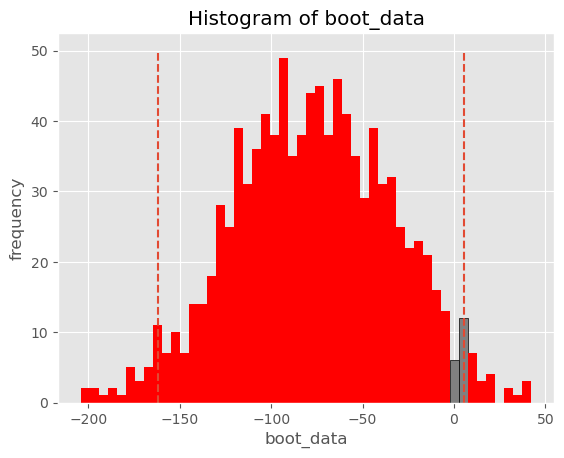

In [5]:
booted_data = get_bootstrap(df.sample_1, df.sample_2) 


In [7]:
booted_data["p_value"] 

0.07704553867678232

In [8]:
booted_data["quants"] 

,0
0.025,-161.943418
0.975,5.328283


Please note that the data above was generated; in this case, we will take them from a dataset.

In [6]:
data_ab = pd.read_csv('hw_bootstrap.csv', sep=';', decimal=',')

In [7]:
data_ab.head()

,Unnamed: 0,value,experimentVariant
0,1,9.773113,Treatment
1,2,9.311246,Treatment
2,3,11.172828,Treatment
3,4,11.624510,Treatment
4,5,10.462331,Treatment


In [8]:
data_ab.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

We can see that in the Treatment sample, there are 50 observations, which may seem low at first glance. Indeed, in my personal opinion, it is indeed on the lower side. Most likely, the t-test will struggle here, but let's continue to examine the results further. Additionally, in statistical books and articles, it is often mentioned that if there are fewer than 30 observations in the data, the Mann-Whitney test should be used; if there are more than 30, the t-test should be used. However, as I mentioned earlier, this is not entirely accurate because it's important to consider the distribution of the data.

In [9]:
data_ab.groupby('experimentVariant').agg({'value': 'count'})

,value
experimentVariant,
Control,500
Treatment,50


We can see that the means and medians are generally very similar to each other, with very small differences. However, it's important to understand that statistics do not judge whether these differences are large or small; rather, it's more important to determine whether these observations are random. Although the results may appear very similar, even small differences that we find in the industry can be significant when shared with a larger audience, leading to a favorable outcome. This is akin to medicine: if we find even small differences, for example, in an experiment comparing a new drug to an old one, it's not so important that they are small; what matters is that they exist and are not random, indicating a direction we should pursue.

In [10]:
data_ab.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,10.367236


In [11]:
data_ab.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.420193


<Axes: xlabel='experimentVariant', ylabel='value'>

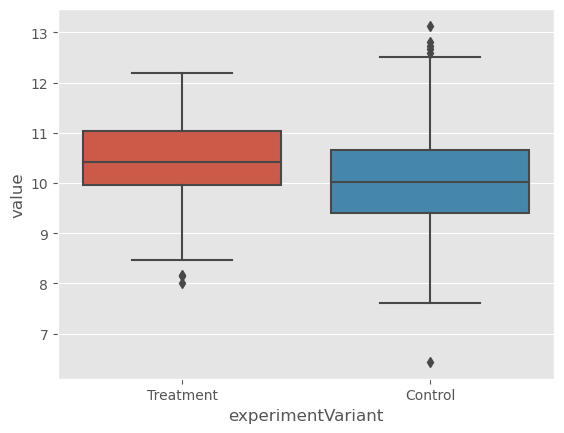

In [12]:
sns.boxplot(x="experimentVariant", y="value", data=data_ab)

C:\Users\tuf\AppData\Local\Temp\ipykernel_8076\926377123.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_ab[data_ab.experimentVariant == 'Control'].value, kde=False)


<Axes: xlabel='value'>

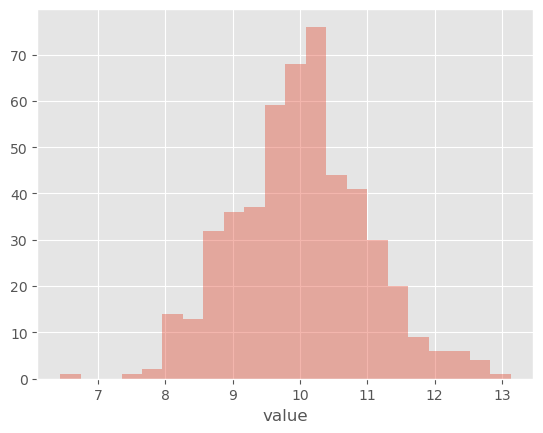

In [13]:
sns.distplot(data_ab[data_ab.experimentVariant == 'Control'].value, kde=False)

As we can see, our small sample does not approximate a normal distribution very well. This might not be because the means are distributed non-normally, but rather because it's simply a small sample.

C:\Users\tuf\AppData\Local\Temp\ipykernel_8076\760479979.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_ab[data_ab.experimentVariant == 'Treatment'].value, kde=False)


<Axes: xlabel='value'>

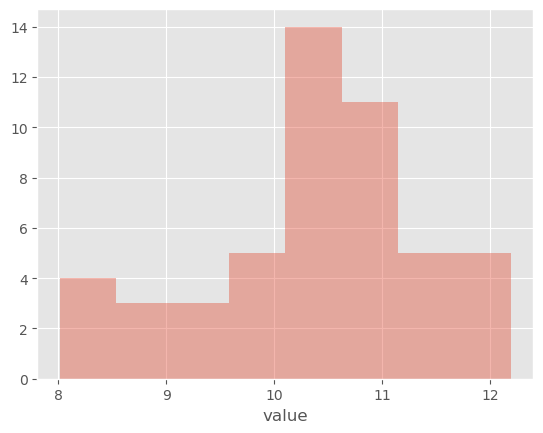

In [14]:
sns.distplot(data_ab[data_ab.experimentVariant == 'Treatment'].value, kde=False)

в таких случаях можно иIn such cases, you can use either a box plot or a QQ plot to assess normality. A box plot can help visually assess asymmetry and the presence of outliers in the data, while a QQ plot can compare sample quantiles with theoretical quantiles of a normal distribution, providing a more formal assessment of normality.сползовать или box plot или qq-plot

In [47]:
mannwhitneyu(data_ab[data_ab.experimentVariant == 'Treatment'].value, 
             data_ab[data_ab.experimentVariant == 'Control'].value)

MannwhitneyuResult(statistic=9508.0, pvalue=0.0026182097937983984)

In [48]:
ttest_ind(data_ab[data_ab.experimentVariant == 'Treatment'].value, 
             data_ab[data_ab.experimentVariant == 'Control'].value)

Ttest_indResult(statistic=2.3318589655730135, pvalue=0.02006953912735476)

We see that the values are significant but entirely different in "mass". Mann-Whitney U test provides more significant results when the t-test is on the brink of decision-making.








Using bootstrap, we can see that 0 does not fall within the confidence interval, indicating that the results are significant.

  0%|          | 0/1000 [00:00<?, ?it/s]

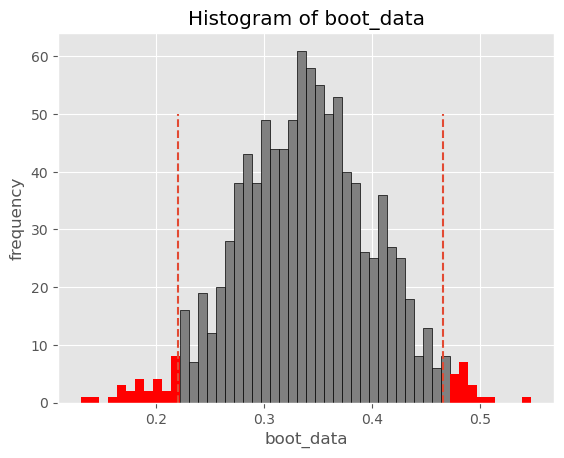

{'boot_data': [0.18776922743289298,
  0.2743838675211076,
  0.3909727989808199,
  0.3904828832226607,
  0.31485717935864965,
  0.3069757794930818,
  0.3362924106925129,
  0.24950386781883185,
  0.28549502999860166,
  0.3264786929742884,
  0.3346640724381806,
  0.20350194545007164,
  0.36711279749907455,
  0.375955783001078,
  0.4763711687140301,
  0.21050188748730733,
  0.39965962726509974,
  0.21706371747252265,
  0.3205050287524081,
  0.2999072255449677,
  0.3451589979116176,
  0.3711652313496434,
  0.487194465404953,
  0.38663407840311725,
  0.4291399125597985,
  0.3559036189255172,
  0.3610108676411262,
  0.2950572590683744,
  0.31109350067948716,
  0.35442805077715583,
  0.34979957789697175,
  0.3667140741186572,
  0.2904463981998923,
  0.42686031890116566,
  0.341652008102179,
  0.35767692844111876,
  0.3436850660528668,
  0.4083918267424844,
  0.28116169911536243,
  0.3747434483761955,
  0.39999030352400655,
  0.35416193032476184,
  0.3626667443237265,
  0.3108938088118633,
  0.

In [15]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, 
    data_ab[data_ab.experimentVariant == 'Control'].value, 
    boot_it = 1000,
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
)

the same situation with median

  0%|          | 0/1000 [00:00<?, ?it/s]

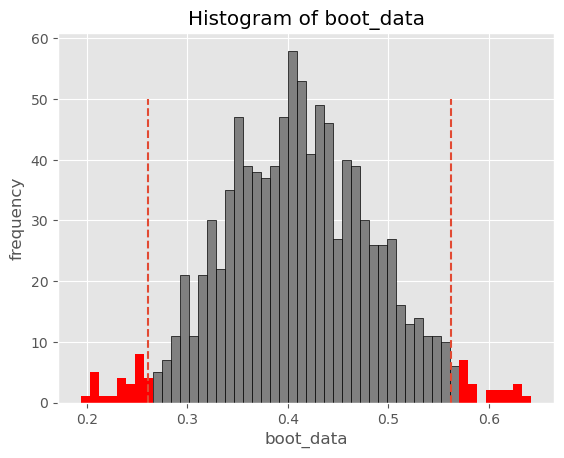

{'boot_data': [0.4759590488007044,
  0.44919718704470046,
  0.3980850896149004,
  0.3608391225914547,
  0.42894577490037467,
  0.5177598200697888,
  0.46535184538277985,
  0.5216242095347852,
  0.42673026232804023,
  0.62161333416711,
  0.6044745340126507,
  0.38857443843664985,
  0.4355556135150298,
  0.29364374617110034,
  0.4142134813097198,
  0.41144980025370037,
  0.31347990476915477,
  0.48392564486073475,
  0.446982442825651,
  0.41460889208093565,
  0.4515132516660145,
  0.34388991400254554,
  0.42707226369779505,
  0.3834338893270992,
  0.30457351226240004,
  0.40081608397083457,
  0.454579907957104,
  0.4031289695497815,
  0.4441734506115651,
  0.4405413255045154,
  0.37475009229738454,
  0.29152425843473484,
  0.3906667841172,
  0.31474915236985,
  0.43414578468348,
  0.472984033859575,
  0.5017382678905644,
  0.4432384102167397,
  0.3638246107155503,
  0.29613859624205485,
  0.2521697111478156,
  0.4174575927235349,
  0.40600335444540026,
  0.4363476563528996,
  0.424638008

In [16]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value,
    data_ab[data_ab.experimentVariant == 'Control'].value, 
    boot_it = 1000, 
    statistic = np.median, 
    bootstrap_conf_level = 0.95 
)

Nevertheless, despite bootstrap being a powerful tool, it is not a panacea. Statistics perform poorly with small datasets. As a conclusion, both bootstrap and Mann-Whitney tests showed much better results than the t-test.